In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from numpy.polynomial import Polynomial as P

In [30]:
PREV_LEFT_X1 = None
PREV_LEFT_X2 = None
PREV_RIGHT_X1 = None
PREV_RIGHT_X2 = None

### Conversion to HSV Color space and grayscal

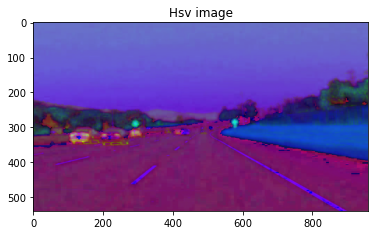

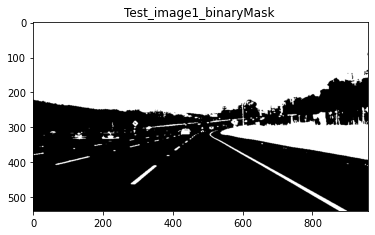

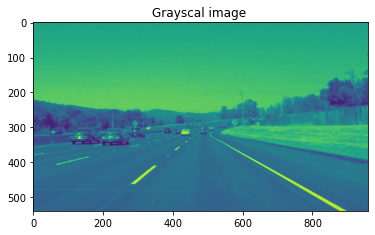

In [31]:
original = cv2.imread('Test_images\Test_image1.jpg')
original_copy=np.copy(original)
road= cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
roadgray= cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
ret, bw_img = cv2.threshold(roadgray,127,255,cv2.THRESH_BINARY)
roadhsv= cv2.cvtColor(road, cv2.COLOR_RGB2HSV)
plt.title('Hsv image')
plt.imshow(roadhsv)
#plt.savefig('Results/Flower_Fy_1')
plt.show()
plt.title('Test_image1_binaryMask ')
plt.imshow(bw_img, cmap='gray')
cv2.imwrite('Results/Test_image1_binaryMask.jpg', bw_img)
plt.show()
plt.title('Grayscal image ')
plt.imshow(roadgray)
plt.show()

### Gaussian blur

In [32]:
def Gaussian_Blur(image, kernel_size):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

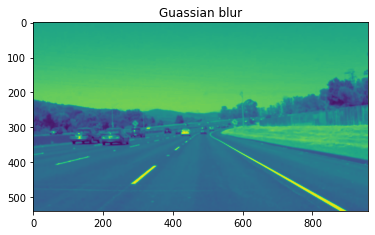

In [33]:
Guassian_blur=Gaussian_Blur(roadgray, 5)
plt.title('Guassian blur')
plt.imshow(Guassian_blur)
plt.show()

### Binary Mask for yellow and white colored pixels


In [34]:
def select_rgb_white_yellow(image): 
    lower = np.uint8([190, 190, 190])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    
    lower = np.uint8([170, 170, 0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    
    # combine two maskz
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

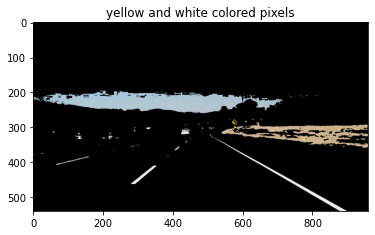

In [35]:
white_yellow=select_rgb_white_yellow(road)
plt.title('yellow and white colored pixels')
cv2.imwrite('Results/Test_image1_filteredImage.jpg', white_yellow)
plt.imshow(white_yellow , cmap='gray')
plt.show()

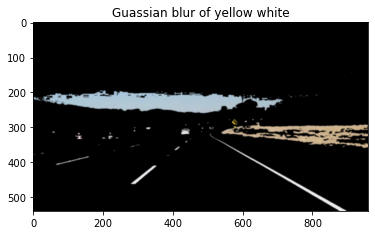

In [36]:
Guassian_blurofyw=Gaussian_Blur(white_yellow, 5)
plt.title('Guassian blur of yellow white pixels')
plt.imshow(Guassian_blurofyw,cmap='gray')
plt.show()

### Canny edge to degtect edges on guassian blur image

In [37]:
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

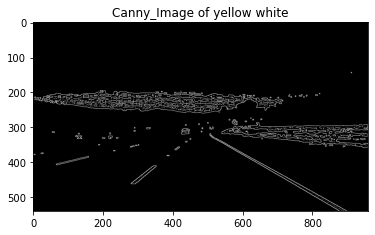

In [38]:
Canny_Image=detect_edges(Guassian_blurofyw, low_threshold=0.1, high_threshold=0.5)
plt.title('Canny_Image of yellow white')
cv2.imwrite('Results/Test_image1_edges.jpg', Canny_Image)
plt.imshow(Canny_Image, cmap='gray')
plt.show()

### Compute Region of interest

In [39]:
def filter_region(image, vertices):
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2])   
    return cv2.bitwise_and(image, mask)
    
def select_region(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)



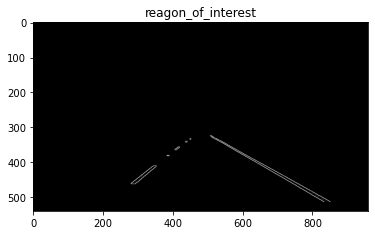

In [40]:
reagon_of_interest = select_region(Canny_Image)
plt.title('reagon_of_interest')
cv2.imwrite('Results/Test_image1_ROI.jpg', reagon_of_interest)
plt.imshow(reagon_of_interest, cmap='gray')
plt.show()

### Linear Regression function on two group of lines 

In [41]:

def slope(line):
    return (float(line[3]) - line[1]) / (float(line[2]) - line[0])

def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    global PREV_LEFT_X1, PREV_LEFT_X2, PREV_RIGHT_X1, PREV_RIGHT_X2
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    for line in lines:
        line = line[0]
        s = slope(line)
        if 0.3 > s > -0.3:
            continue
        if s < 0:
            if line[0] > img.shape[1] / 2 + 40:
                continue

            left_x += [line[0], line[2]]
            left_y += [line[1], line[3]]
        else:
            if line[0] < img.shape[1] / 2 - 40:
                continue
            right_x += [line[0], line[2]]
            right_y += [line[1], line[3]]
    y1 = img.shape[0]
    y2 = img.shape[0] / 2 + 90

    if len(left_x) <= 1 or len(right_x) <= 1:
        if PREV_LEFT_X1 is not None:
            cv2.line(img, (int(PREV_LEFT_X1), int(y1)), (int(PREV_LEFT_X2), int(y2)), color, thickness)
            cv2.line(img, (int(PREV_LEFT_X2), int(y1)), (int(PREV_RIGHT_X2), int(y2)), color, thickness)
        return

    left_poly = P.fit(np.array(left_x), np.array(left_y), 1)
    right_poly = P.fit(np.array(right_x), np.array(right_y), 1)

    left_x1 = (left_poly - y1).roots()
    right_x1 = (right_poly - y1).roots()

    left_x2 = (left_poly - y2).roots()
    right_x2 = (right_poly - y2).roots()

    if PREV_LEFT_X1 is not None:
        left_x1 = PREV_LEFT_X1 * 0.7 + left_x1 * 0.3
        left_x2 = PREV_LEFT_X2 * 0.7 + left_x2 * 0.3
        right_x1 = PREV_RIGHT_X1 * 0.7 + right_x1 * 0.3
        right_x2 = PREV_RIGHT_X2 * 0.7 + right_x2 * 0.3

    PREV_LEFT_X1 = left_x1
    PREV_LEFT_X2 = left_x2
    PREV_RIGHT_X1 = right_x1
    PREV_RIGHT_X2 = right_x2

    cv2.line(img, (int(left_x1), int(y1)), (int(left_x2), int(y2)), color, thickness)
    cv2.line(img, (int(right_x1), int(y1)), (int(right_x2), int(y2)), color, thickness)


### Hough Transformation algorithm to filter unwanted lines

In [42]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=7)
    return line_img

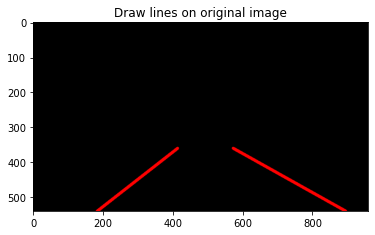

In [48]:
Hough_transform=hough_lines(reagon_of_interest, 1, np.pi /90, 10, 15, 10)
plt.title('Draw lines on original image')
plt.imshow(Hough_transform)
cv2.imwrite('Results/Test_image1_linear_regression.jpg', Hough_transform)
plt.show()

### Show these lines on original Image

In [44]:
def weighted_img(img, initial_img, α=1., β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

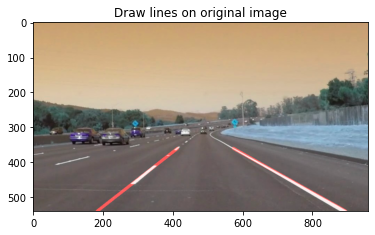

In [45]:
final_img = weighted_img(Hough_transform, original_copy,α=1., β=1., λ=1.)
plt.title('Draw lines on original image')
cv2.imwrite('Results/Test_image1_output.jpg', final_img)
plt.imshow(final_img)
plt.show()